## SPEI calculation issue at low PET locations

See https://github.com/monocongo/climate_indices/issues/441. 

This notebook attempts to demonstrate this issue using TerraClimate. Cells that cause issues have been pre-identified.

In [3]:
import xarray as xr

terra_precip = xr.open_dataset('http://thredds.northwestknowledge.net/thredds/dodsC/agg_terraclimate_ppt_1958_CurrentYear_GLOBE.nc')
terra_pet = xr.open_dataset('http://thredds.northwestknowledge.net/thredds/dodsC/agg_terraclimate_pet_1958_CurrentYear_GLOBE.nc')

Select cell via thredds to demonstrate

In [91]:
# SPEI-1 at lat=37.31 lon=75.31

test_cell_lat = 37.31
test_cell_lon = 75.31

subset_precip = terra_precip.sel(dict(time=slice('1979-01-01', '2021-01-01'))) \
                            .sel(lat=test_cell_lat, lon=test_cell_lon, method='nearest').ppt

subset_pet = terra_pet.sel(dict(time=slice('1979-01-01', '2021-01-01'))) \
                            .sel(lat=test_cell_lat, lon=test_cell_lon, method='nearest').pet


### Plot PET + precip for issue cell

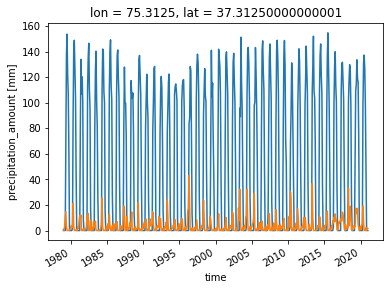

In [122]:
subset_pet.plot();
subset_precip.plot();

Note the high-ish count of zero PET timesteps (months). This is in a high altitude area.

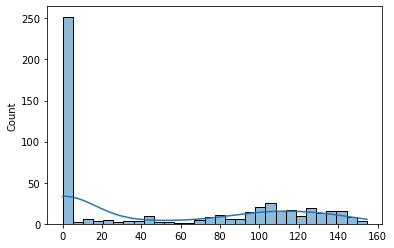

In [96]:
import seaborn
seaborn.histplot(subset_pet.values, bins=30,kde=True);

In [30]:
subset_pet[subset_pet == 0].count()

<xarray.DataArray 'pet' ()>
array(240)
Coordinates:
    lon      float64 75.31
    lat      float64 37.31

Show the l-moment error for this cell using 1 month SPEI calculation

In [101]:
from climate_indices import compute, indices

indices.spei(precips_mm=subset_precip.values,
    pet_mm= subset_pet.values,
    scale=1,
    distribution=indices.Distribution.pearson,
    periodicity=compute.Periodicity.monthly,
    data_start_year=1979,
    calibration_year_initial=1979,
    calibration_year_final=2010
)

2022-08-11  11:18:18 ERROR Unable to calculate Pearson Type III parameters due to invalid L-moments:
2022-08-11  11:18:18 ERROR [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
2022-08-11  11:18:18 ERROR [0. 0. 0.]


ValueError: Unable to calculate Pearson Type III parameters due to invalid L-moments:

Does not happen for 3-month calculation

In [123]:
from climate_indices import compute, indices

indices.spei(precips_mm=subset_precip.values,
    pet_mm= subset_pet.values,
    scale=3,
    distribution=indices.Distribution.pearson,
    periodicity=compute.Periodicity.monthly,
    data_start_year=1979,
    calibration_year_initial=1979,
    calibration_year_final=2010
)

array([            nan,             nan, -8.03301516e-01,  3.34212433e-01,
        1.08645877e+00,  3.88013955e-01, -4.12107500e-01, -1.27507552e+00,
       -1.28817702e+00, -1.85245589e+00, -2.08520230e+00, -1.90644192e+00,
       -2.47057821e-01,  2.91213274e-01,  3.04018489e-01, -4.00313792e-01,
        1.65034467e-01, -3.82017335e-01, -7.07078525e-01, -1.41071109e+00,
       -1.22241835e+00, -1.15708648e+00, -9.77192327e-01, -9.36138703e-01,
       -2.92025007e-01, -4.33371115e-01,  7.32489175e-01,  1.16359124e+00,
        8.02780413e-01,  4.03898566e-01,  7.08724307e-01,  5.11102097e-01,
        6.72183680e-01,  4.99466030e-01,  6.39059111e-01,  1.08824869e+00,
       -1.75723492e+00, -1.34936437e+00, -8.03301516e-01,  5.74215901e-01,
       -1.19066544e+00, -9.22528530e-01, -1.47575363e+00, -3.16975100e-01,
       -9.67920856e-02,  8.46903792e-01,  7.29119428e-01,  1.09412596e+00,
        9.37098697e-02, -5.94112972e-01,  1.14254454e-01, -9.54327244e-02,
       -1.80798277e-01, -

Replace the zeros with rand float between 0-10

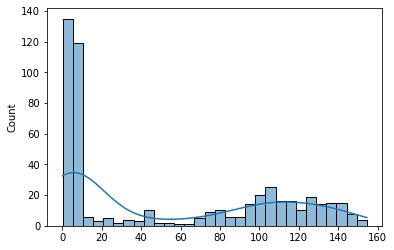

In [124]:
import random
import numpy as np

def fill_rand(value):
    if value == 0.0:
        return random.uniform(0.1, 10)
    else:
        return value

pet_filled = np.array(list(map(fill_rand, subset_pet.values)))
seaborn.histplot(pet_filled, bins=30, kde=True);

And test with adjusted PET array

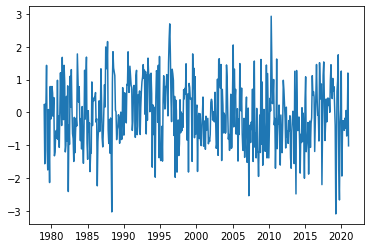

In [125]:
spei_result = indices.spei( precips_mm=subset_precip.values,
    pet_mm = pet_filled,
    scale=1,
    distribution=indices.Distribution.pearson,
    periodicity=compute.Periodicity.monthly,
    data_start_year=1980,
    calibration_year_initial=1990,
    calibration_year_final=2010
)

seaborn.lineplot(y=spei_result, x=subset_pet.time.values);